In [1]:
import os, glob, torch, numpy as np
from types import SimpleNamespace
import matplotlib.pyplot as plt
from tqdm import tqdm

from interpolant_new import Interpolant
from utils_forlookback_sevir_vil import DriftModel  # just the model class, no datamodule

SEVIR_DIR = "./data/sevir_lr"
CKPT_PATH = "./checkpoints/latest.pt"
IN_LEN, OUT_LEN = 6, 6 # input & forecast steps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [12]:
class SEVIRNpyDataset(torch.utils.data.Dataset):
    """
    Expects directory of .npy arrays shaped:
      - (T, H, W) or (T, H, W, 1), values in [0,1].
    We create windows of length IN_LEN+OUT_LEN with stride=IN_LEN (non-overlapping).
    """
    def __init__(self, root, in_len=6, out_len=6, stride=None):
        self.files = sorted(glob.glob(os.path.join(root, "*.npy")))
        assert len(self.files) > 0, f"No .npy files found under {root}"
        self.in_len, self.out_len = in_len, out_len
        self.stride = in_len if stride is None else stride
        self.index = []  # list of (file_idx, start_t)

        for i, f in enumerate(self.files):
            arr = np.load(f, mmap_mode="r")  # don’t load into RAM yet
            T = arr.shape[0]
            win = in_len + out_len
            for s in range(0, T - win + 1, self.stride):
                self.index.append((i, s))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        fi, s = self.index[idx]
        x = np.load(self.files[fi])  # (T, H, W) or (T, H, W, 1)
        x = x[s:s + (self.in_len + self.out_len)]
        if x.ndim == 4:  # (T,H,W,1) -> (T,1,H,W)
            x = np.transpose(x, (0, 3, 1, 2))
        else:            # (T,H,W) -> (T,1,H,W)
            x = x[:, None, ...]
        x = torch.from_numpy(x).float()  # assume already in [0,1]
        # Split
        xlo, xhi = x[:self.in_len], x[self.in_len:]
        # Scale *exactly* like your Trainer.prepare_batch_sevir()
        z0 = (xlo - 0.5) * 10   # (in_len,1,H,W)
        z1 = (xhi - 0.5) * 10   # (out_len,1,H,W)
        # return as (B,T,C,H,W) with B=1 for simplicity
        return z0.unsqueeze(0), z1.unsqueeze(0)

# tiny loader
ds = SEVIRNpyDataset(SEVIR_DIR, IN_LEN, OUT_LEN)
z0, z1 = ds[0]          # (1, in_len, 1, H, W), (1, out_len, 1, H, W)
z0, z1 = z0.to(device), z1.to(device)
cond = z0.clone()       # conditioning is the input history

# minimal config stub for model + interpolant
c = SimpleNamespace(
    dataset='sevir', device=device,
    # interpolant/sampling
    sigma_coef=1.0, beta_fn='t^2', t_min_sampling=0.0, t_max_sampling=0.999,
    # unet arch (match training)
    unet_use_classes=False, unet_channels=128, unet_dim_mults=(1,2,2,2),
    unet_resnet_block_groups=8, unet_learned_sinusoidal_dim=32,
    unet_attn_dim_head=64, unet_attn_heads=4,
    unet_learned_sinusoidal_cond=True, unet_random_fourier_features=False,
    # shapes
    C=1, H=z0.shape[-2], W=z0.shape[-1],
)

I = Interpolant(c)
model = DriftModel(c).to(device)
state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state['model_state_dict'])
model.eval();

print("z0:", tuple(z0.shape), "z1:", tuple(z1.shape))


AssertionError: No .npy files found under ./data/sevir_lr

In [ ]:
@torch.no_grad()
def sample_next_frames(model, I, cond, steps=6, em_steps=200):
    """
    Autoregressive rollout: at each step, sample x_{t+1} from base = last(cond),
    with f=bF and g=sigma (sigma_coef=1.0), no observation guidance.
    cond / output are in training scale (~[-5,5]).
    """
    out = []
    for _ in range(steps):
        base = cond[:, -1:].contiguous()               # (B,1,H,W)
        ts = torch.linspace(I.c.t_min_sampling, I.c.t_max_sampling, em_steps, device=cond.device)
        dt = ts[1] - ts[0]
        xt = base.clone()

        for t in ts:
            tvec = t.repeat(xt.shape[0]).to(xt.device)            # (B,)
            D = I.interpolant_coefs({'t': tvec, 'zt': xt, 'z0': base})
            bF = model(xt, tvec, None, cond=cond)                  # drift
            f  = bF
            g  = I.sigma(tvec)                                     # default diffusion
            xt = xt + f * dt + g[:,None,None,None] * torch.randn_like(xt) * dt.sqrt()

        out.append(xt)                       # one predicted frame
        cond = torch.cat([cond[:,1:], xt], dim=1)   # roll the window
    return torch.cat(out, dim=1)             # (B, steps, H, W)

pred = sample_next_frames(model, I, cond, steps=z1.shape[1], em_steps=200)  # predict same horizon as z1

# quick viz of first GT vs Pred frame (convert back to [0,1] for display)
gt0   = (z1[0,0].cpu().numpy()/10 + 0.5)
pred0 = (pred[0,0].cpu().numpy()/10 + 0.5)

fig, ax = plt.subplots(1,2, figsize=(5,2.5))
ax[0].imshow(gt0, cmap='gray', vmin=0, vmax=1);   ax[0].set_title('GT');   ax[0].axis('off')
ax[1].imshow(pred0, cmap='gray', vmin=0, vmax=1); ax[1].set_title('Pred'); ax[1].axis('off')
plt.show()


In [22]:
import h5py
import numpy as np

# Pick one file
num_frames = 4
event_idx = 0
h5_path = "./data/sevir_lr/data/vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0501_0831.h5"

with h5py.File(h5_path, "r") as f:
    # list top-level keys
    print("Keys in file:", list(f.keys()))

    # assume dataset is called 'vil' (common for SEVIR-LR VIL files)
    data = f["vil"]
    frames = data[event_idx, :, :, :num_frames]

    print("Shape:", data.shape)
    print("Dtype:", data.dtype)

    # read one example (first event, first time step)
    if len(data.shape) == 4:   # (N_events, T, H, W)
        sample = data[0, 0]    # (H, W)
    elif len(data.shape) == 3: # (T, H, W)
        sample = data[0]
    else:
        raise ValueError("Unexpected shape", data.shape)

    print("Sample min/max:", np.min(sample), np.max(sample))


Keys in file: ['vil']
Shape: (1440, 128, 128, 25)
Dtype: uint8
Sample min/max: 0 81


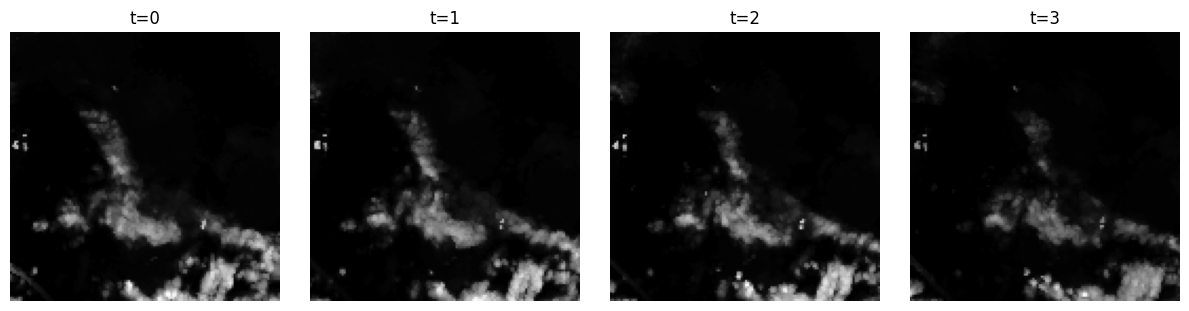

In [25]:
fig, axs = plt.subplots(1, num_frames, figsize=(3*num_frames, 3), constrained_layout=True)
for i in range(num_frames):
    ax = axs[i] if num_frames > 1 else axs
    img = frames[:,:,i]

    # If values aren’t in [0,1], normalize per-frame for display (optional):
    vmin, vmax = np.nanmin(img), np.nanmax(img)
    if vmax > 1 or vmin < 0:
        ax.imshow((img - vmin) / (vmax - vmin + 1e-8), cmap="gray", origin="upper")
    else:
        ax.imshow(img, cmap="gray", origin="upper", vmin=0, vmax=1)

    ax.set_title(f"t={i}")
    ax.axis("off")

plt.show()

# Predictions

In [6]:
import h5py, numpy as np, torch
import matplotlib.pyplot as plt
from types import SimpleNamespace

from utils_forlookback_sevir_vil import DriftModel
from interpolant_new import Interpolant
from tqdm import tqdm

# change these
# h5_path   = "./data/sevir_lr/data/vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0501_0831.h5"
h5_path   = "./data/sevir_lr/data/vil/2017/SEVIR_VIL_STORMEVENTS_2017_0101_0630.h5"
CKPT_PATH = "./checkpoints/latest.pt"

IN_LEN, OUT_LEN = 6, 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [31]:
with h5py.File(h5_path, "r") as f:
    key = "vil" if "vil" in f.keys() else list(f.keys())[0]
    arr = np.array(f[key])     # (N, H, W, T)

# re-order → (N, T, H, W)
arr = np.transpose(arr, (0, 3, 1, 2))
print("Dataset shape (N,T,H,W):", arr.shape)

def normalize_sevir_vil(arr):
    arr = arr.astype(np.float32)
    vmin, vmax = float(arr.min()), float(arr.max())
    print(f"[raw VIL] min={vmin:.3f} max={vmax:.3f} dtype={arr.dtype}")

    # Heuristics for SEVIR encodings:
    # - VIL is typically 0..255 (uint8). Normalize by 255.
    # - If something else slips in (e.g., <= 10000), normalize accordingly.
    if vmax <= 1.5:
        # already [0,1]
        arr01 = arr
    elif vmax <= 255.5:
        arr01 = arr / 255.0
    elif vmax <= 4095.5:
        arr01 = arr / 4095.0
    elif vmax <= 10000.5:
        arr01 = arr / 10000.0
    else:
        # Fallback: robust scaling to [0,1]
        print("[warn] Unexpected VIL range; using min-max normalization.")
        arr01 = (arr - vmin) / max(vmax - vmin, 1e-6)

    print(f"[normed VIL] min={arr01.min():.3f} max={arr01.max():.3f}")
    return arr01

arr = normalize_sevir_vil(arr)  # <-- normalize BEFORE (x - 0.5) * 10

arr = normalize_sevir_vil(arr)

event0 = arr[0]                    # take first event (T,H,W)
xlo, xhi = event0[:IN_LEN], event0[IN_LEN:IN_LEN+OUT_LEN]

# scale same way as training
z0 = (xlo - 0.5) * 10              # (IN_LEN,H,W)
z1 = (xhi - 0.5) * 10              # (OUT_LEN,H,W)

# add batch+channel dims → (B,T,C,H,W)
z0 = torch.from_numpy(z0[None, :, None]).float().to(device)
z1 = torch.from_numpy(z1[None, :, None]).float().to(device)
cond = z0.clone()
print("z0:", tuple(z0.shape), "z1:", tuple(z1.shape))


Dataset shape (N,T,H,W): (193, 25, 128, 128)
[raw VIL] min=0.000 max=254.000 dtype=float32
[normed VIL] min=0.000 max=0.996
[raw VIL] min=0.000 max=0.996 dtype=float32
[normed VIL] min=0.000 max=0.996
z0: (1, 6, 1, 128, 128) z1: (1, 6, 1, 128, 128)


In [32]:
z0.max()

tensor(4.9608, device='cuda:0')

In [33]:
c = SimpleNamespace(
    dataset='sevir', device=device,
    sigma_coef=1.0, beta_fn='t^2', t_min_sampling=0.0, t_max_sampling=0.999,
    unet_use_classes=False, unet_channels=128, unet_dim_mults=(1,2,2,2),
    unet_resnet_block_groups=8, unet_learned_sinusoidal_dim=32,
    unet_attn_dim_head=64, unet_attn_heads=4,
    unet_learned_sinusoidal_cond=True, unet_random_fourier_features=False,
    C=1, H=z0.shape[-2], W=z0.shape[-1],
    num_classes=1,
)

I = Interpolant(c)
model = DriftModel(c).to(device)
state = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state['model_state_dict'])
model.eval();


NOT USING CLASSES IN UNET
Num params in main arch for drift is 30,020,113


In [34]:
@torch.no_grad()
def rollout(model, I, z0_time, steps, em_steps=200):
    """
    z0_time: (B, 6, 1, H, W)  -- 6 lookback frames, C=1
    returns: (B, steps, 1, H, W)
    """
    assert z0_time.dim() == 5, f"z0_time must be 5D (B,6,1,H,W), got {z0_time.shape}"
    B, T, C, H, W = z0_time.shape
    assert T == 6 and C == 1, f"Expected (B,6,1,H,W), got {z0_time.shape}"

    # stack 6 frames along channels -> (B, 6, H, W)
    cond_chn = z0_time.flatten(start_dim=1, end_dim=2).contiguous().float()
    out = []

    for _ in tqdm(range(steps)):
        # base/current state: (B,1,H,W)
        base = z0_time[:, -1, 0].unsqueeze(1).contiguous().float()   # NCHW
        xt = base.clone()

        ts = torch.linspace(I.config.t_min_sampling, I.config.t_max_sampling, em_steps, device=z0_time.device)
        dt = ts[1] - ts[0]

        for t in ts:
            tvec = t.repeat(B).to(xt.device)  # (B,)

            # keep xt strictly NCHW
            if xt.dim() != 4:
                xt = xt.view(B, 1, H, W)

            # (optional) interpolant precompute; ignore outputs
            _ = I.interpolant_coefs({'t': tvec, 'zt': xt, 'z0': base})

            # ----- model call -----
            bF = model(xt, tvec, None, cond=cond_chn)  # expected (B,1,H,W)

            # squash any stray singleton axes the model might return
            if bF.dim() != 4:
                # keep the last 2 as H,W; coerce to (B,1,H,W)
                bF = bF.view(B, 1, H, W)

            # diffusion
            g = I.sigma(tvec)
            if g.dim() == 1:
                g = g[:, None, None, None]            # (B,1,1,1)
            elif g.dim() != 4:
                g = g.view(B, 1, 1, 1)

            # EM update, keep result NCHW
            xt = xt + bF * dt + g * torch.randn_like(xt) * dt.sqrt()
            if xt.dim() != 4:
                xt = xt.view(B, 1, H, W)

        out.append(xt.unsqueeze(1))  # (B,1,1,H,W)

        # roll cond buffer in channels: (B,6,H,W) -> drop first, append xt
        cond_chn = torch.cat([cond_chn[:, 1:], xt], dim=1)  # still (B,6,H,W)

        # keep 5D time buffer if you want it elsewhere
        z0_time = torch.cat([z0_time[:, 1:], xt.unsqueeze(1)], dim=1)  # (B,6,1,H,W)

    return torch.cat(out, dim=1)  # (B,steps,1,H,W)


In [35]:
N_SAMPLES = 3
# z0: (1, 6, 1, H, W)  → repeat along batch
z0_multi = z0.repeat(N_SAMPLES, 1, 1, 1, 1)   # (N, 6, 1, H, W)

preds = rollout(model, I, z0_multi, steps=z1.shape[1], em_steps=200)
print("preds:", preds.shape)  # (N, steps, 1, H, W)


100%|██████████| 6/6 [01:19<00:00, 13.22s/it]

preds: torch.Size([3, 6, 1, 128, 128])


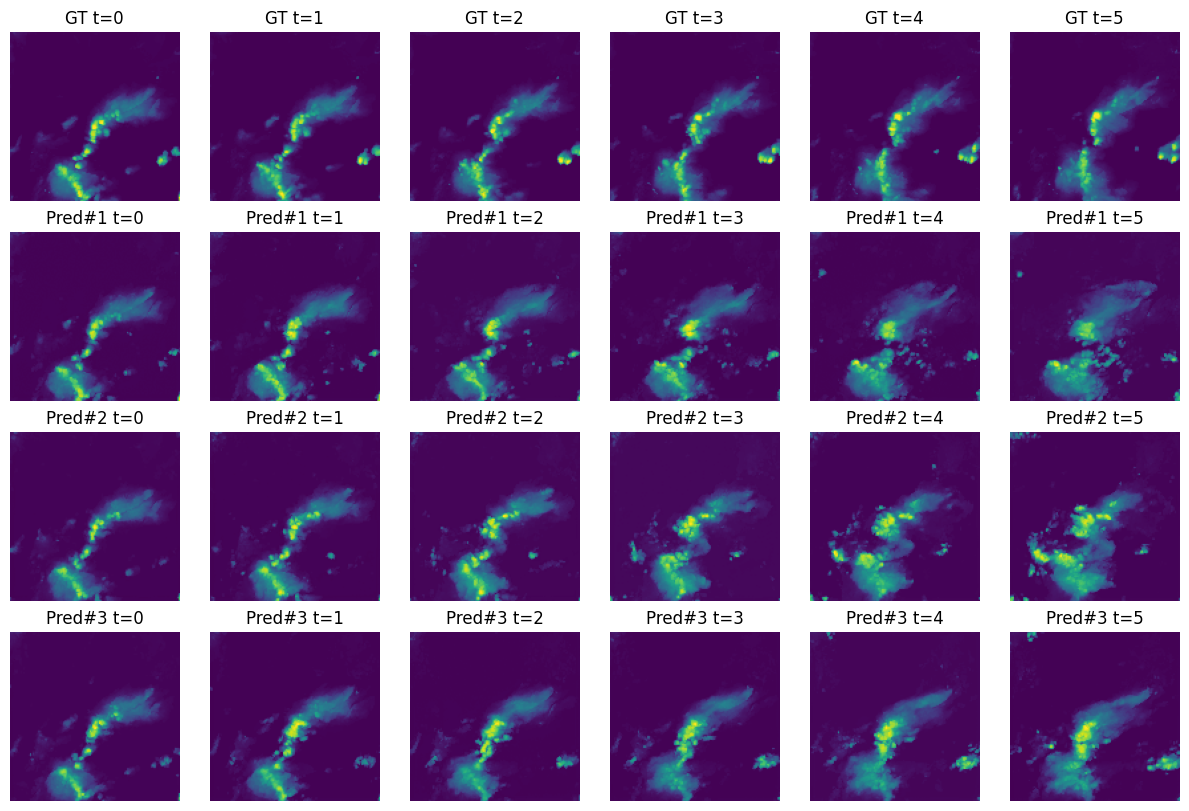

In [38]:
B = 3
gt = z1.repeat(B, 1, 1, 1, 1)              # (3, steps, 1, H, W) for easy plotting alignment

# convert to [0,1] for display
gt_np   = (gt[:, :, 0].cpu().numpy()   / 10 + 0.5)   # (3, steps, H, W)
pred_np = (preds[:, :, 0].cpu().numpy() / 10 + 0.5)  # (3, steps, H, W)

T = gt_np.shape[1]  # number of forecast steps

fig, axs = plt.subplots(1 + B, T, figsize=(2*T, 2*(1+B)), constrained_layout=True)

# row 0: GT
for t in range(T):
    ax = axs[0, t] if B > 1 else axs[t]
    ax.imshow(gt_np[0, t])
    ax.set_title(f"GT t={t}"); ax.axis("off")

# rows 1..B: predictions
for b in range(B):
    for t in range(T):
        ax = axs[1 + b, t] if B > 1 else axs[t]
        ax.imshow(pred_np[b, t])
        ax.set_title(f"Pred#{b+1} t={t}")
        ax.axis("off")

plt.show()


# Guided rollout

In [39]:
# --- simple observation model (same spirit as original) ---
B1, H, W = z1.shape[0], z1.shape[-2], z1.shape[-1]  # z1: (B, OUT_LEN, 1, H, W)

# 10% random mask operator (broadcasts over batch/time)
ratio = 0.10
mask = (torch.rand(1, 1, H, W, device=z1.device) < ratio).float()
operator = lambda x: x * mask

def add_gaussian_noise(x, sigma=0.05):
    return x + sigma * torch.randn_like(x)

# measurements for each forecast step, derived from ground-truth future frames (in training scale)
# y_meas shape: (B, OUT_LEN, 1, H, W)
y_meas = add_gaussian_noise(operator(z1))
print("y_meas:", tuple(y_meas.shape))


y_meas: (1, 6, 1, 128, 128)


In [42]:
def _sigma_int_analytic(tvec, B, H, W, device):
    # matches the "analytical True" term used in their taylor_est* (per-batch scalar → broadcast)
    sqrt_t = tvec.sqrt()                              # (B,)
    val = (2.0/3.0 - sqrt_t + (sqrt_t**3)/3.0)        # (B,)
    return val.view(B, 1, 1, 1).to(device)            # (B,1,1,1)

def rollout_batched_guided(model, I, z0_time, y_meas, em_steps=200, guidance_scale=1.):
    """
    z0_time : (B, 6, 1, H, W)  -- 6-frame lookback (training scale)
    y_meas  : (B, T, 1, H, W)  -- per-step measurements from GT (operator+noise)
    returns : (B, T, 1, H, W)  -- predictions (training scale)
    """
    assert z0_time.dim() == 5 and z0_time.shape[1] == 6 and z0_time.shape[2] == 1
    B, _, _, H, W = z0_time.shape
    T = y_meas.shape[1]
    device = z0_time.device

    # stack 6 lookback frames along channels  -> (B, 6, H, W)
    cond_chn = z0_time.flatten(start_dim=1, end_dim=2).contiguous().float()
    preds = []

    ts = torch.linspace(I.config.t_min_sampling, I.config.t_max_sampling, em_steps, device=device)
    dt = ts[1] - ts[0]

    for step in tqdm(range(T)):
        
        # base/current state is last conditioning frame: (B,1,H,W)
        base = z0_time[:, -1, 0].unsqueeze(1).contiguous().float()
        xt = base.clone().detach().requires_grad_(True)

        meas = y_meas[:, step]  # (B,1,H,W) measurement for this forecast horizon
    
        for t in ts:
            tvec = t.repeat(B).to(device)                 # (B,)

            # drift and diffusion
            bF = model(xt, tvec, None, cond=cond_chn)     # (B,1,H,W)
            g  = I.sigma(tvec).view(B, 1, 1, 1)           # (B,1,1,1)
            f  = bF

            # 2nd-order-ish x1 estimate used only for guidance gradient (mirrors their taylor_est2rd_x1 "analytical" flavor)
            sigma_int = _sigma_int_analytic(tvec, B, H, W, device)
            x1_hat = xt + bF * (1.0 - tvec).view(B,1,1,1) + torch.randn_like(xt) * sigma_int

            # compute gradient of || measurement - noiser(operator(x1_hat)) || w.r.t. xt
            diff = (meas - add_gaussian_noise(operator(x1_hat), sigma=0.0))  # no extra noise in the graph
            norm = torch.linalg.norm(diff.reshape(B, -1), dim=1).sum()       # scalar
            grad = torch.autograd.grad(norm, xt, retain_graph=False, create_graph=False, allow_unused=True)[0]
            if grad is None:
                grad = torch.zeros_like(xt)

            # EM step with guidance
            with torch.no_grad():
                mu = xt + f * dt
                noise = torch.randn_like(mu)
                xt_new = mu + g * noise * dt.sqrt() - guidance_scale * grad

            # re-enable grad for next iteration
            xt = xt_new.detach().requires_grad_(True)

        preds.append(xt.detach().unsqueeze(1))            # (B,1,1,H,W)

        # roll AR window: drop oldest channel, append new prediction channel
        with torch.no_grad():
            cond_chn = torch.cat([cond_chn[:, 1:], xt.detach()], dim=1)          # (B,6,H,W)
            z0_time  = torch.cat([z0_time[:, 1:], xt.detach().unsqueeze(1)], dim=1)  # (B,6,1,H,W)

    return torch.cat(preds, dim=1)   # (B, T, 1, H, W)


In [43]:
# replicate the same initial history across batch to get multiple stochastic guided forecasts
B = 3
z0_multi   = z0.repeat(B, 1, 1, 1, 1)        # (3,6,1,H,W)
y_meas_mul = y_meas.repeat(B, 1, 1, 1, 1)    # (3,T,1,H,W)  (same measurements per batch)

preds_guided = rollout_batched_guided(model, I, z0_multi, y_meas_mul, em_steps=200, guidance_scale=0.1)
print("preds_guided:", tuple(preds_guided.shape))  # (3, T, 1, H, W)

100%|██████████| 6/6 [02:43<00:00, 27.31s/it]

preds_guided: (3, 6, 1, 128, 128)


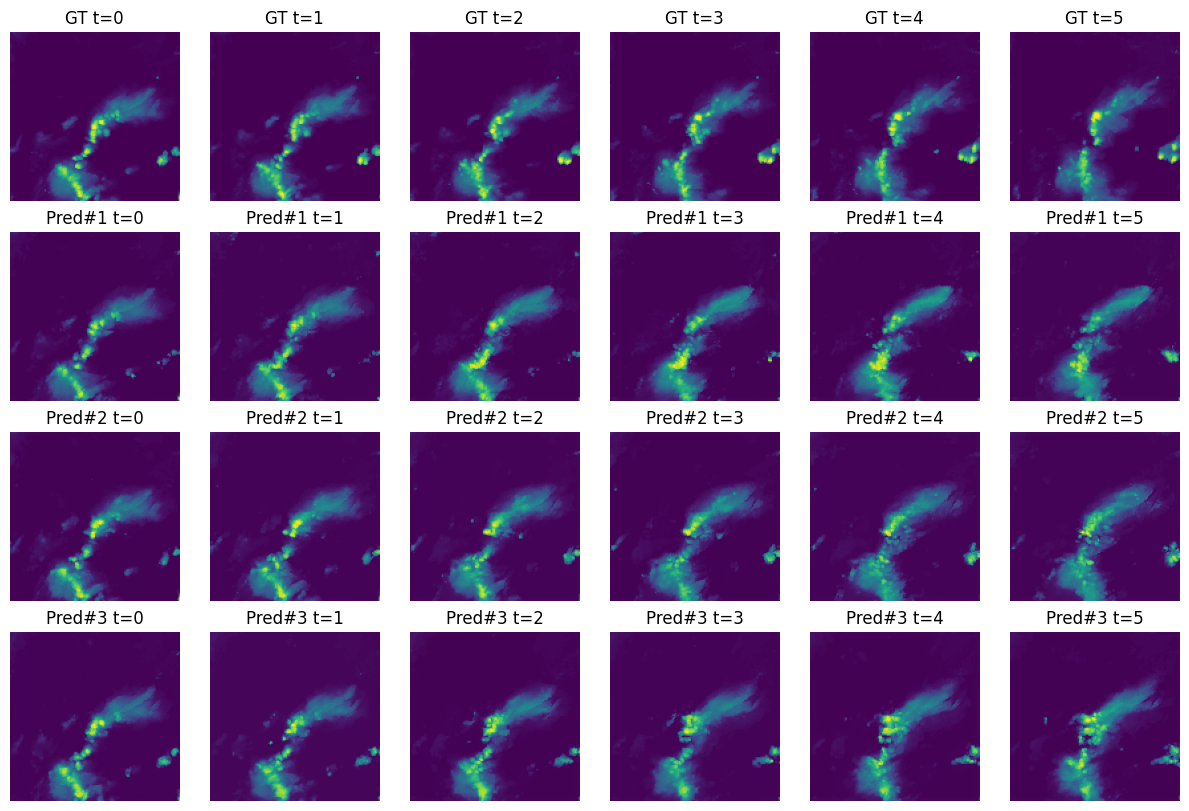

In [45]:
# If you have preds_guided, use that; otherwise use preds
P = preds_guided if 'preds_guided' in globals() else preds   # (B, T, 1, H, W)
B = 3
T = P.shape[1]

# Convert from training scale (~[-5,5]) to display [0,1]
gt_disp   = (z1.repeat(B,1,1,1,1)[:, :, 0].cpu().numpy()/10.0 + 0.5)   # (B,T,H,W)
pred_disp = (P[:, :, 0].cpu().numpy()/10.0 + 0.5)                      # (B,T,H,W)

fig, axs = plt.subplots(1 + B, T, figsize=(2*T, 2*(1+B)), constrained_layout=True)

# row 0: GT (show one GT row for reference)
for t in range(T):
    ax = axs[0, t]
    ax.imshow(gt_disp[0, t], origin="upper")
    ax.set_title(f"GT t={t}")
    ax.axis("off")

# rows 1..B: predictions
for b in range(B):
    for t in range(T):
        ax = axs[1 + b, t]
        ax.imshow(pred_disp[b, t], origin="upper")
        ax.set_title(f"Pred#{b+1} t={t}")
        ax.axis("off")

plt.show()

In [25]:
gt_disp.max()

np.float32(254.0)

In [30]:
z1.max()

tensor(2535., device='cuda:0')